In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv
/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip
/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip


In [3]:
import math, re, os
import numpy as np
import tensorflow as tf

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


In [4]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2022-12-24 19:06:36.084373: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-24 19:06:36.086838: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-24 19:06:36.086864: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-24 19:06:36.086891: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (67a76ffed329): /proc/driver/nvidia/version does not exist
2022-12-24 19:06:36.090014: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8


In [5]:
from kaggle_datasets import KaggleDatasets
GCS_PATH = KaggleDatasets().get_gcs_path()

print(GCS_PATH) # what do gcs paths look like?

gs://kds-8e11a5f440cd2bff2b82099f799c31137b32168d84ec8d31b68a534d


In [6]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://10.0.0.2:8470')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

2022-12-24 19:06:41.447204: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-12-24 19:06:41.447268: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}
2022-12-24 19:06:41.451907: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-12-24 19:06:41.452182: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}


In [7]:
#!pip install tensorflow-gpu==2.4.0

In [8]:
import zipfile

z= zipfile.ZipFile('/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip')
z.extractall()

z= zipfile.ZipFile('/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip')
z.extractall()

In [9]:
df = pd.read_csv('train.tsv', sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


# Preprocessing

<AxesSubplot:>

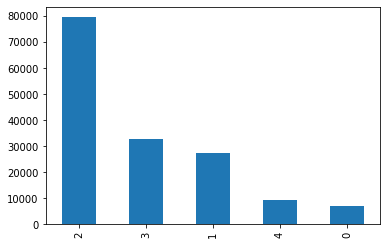

In [10]:
df['Sentiment'].value_counts().plot(kind = 'bar')

In [11]:
seq_len = 512
num_samples = len(df)

num_samples, seq_len

(156060, 512)

In [12]:
from transformers import BertTokenizer

In [13]:
!pip install bert-for-tf2
!pip install ipywidgets

     |████████████████████████████████| 41 kB 121 kB/s eta 0:00:011
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30534 sha256=e2c850b7559e5a2aabf1a11dc820bc5ff82153c91c8460d192840dffab8b59f9
  Stored in directory: /root/.cache/pip/wheels/47/b6/e5/8c76ec779f54bc5c2f1b57d2200bb9c77616da83873e8acb53
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19473 sha256=4222d126d10c4e3d965d39b58faeb29093bed2cc8afff90eb05f6ff0fbe0e9b2
  Stored in directory: /root/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7912 sha256=0650125039037ad5ade65e08b121f5f37a610c8e2df5d3fb701076c89e1be7d7
  Stored in directory: /root/.cache/pip/wheels/e1/11/67/33cc51bbee127cb8fb2ba549cd29109b2f22da43ddf9969716
Successfully built bert-for-tf2 params-flow py-params


In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [15]:
tokens = tokenizer(df['Phrase'].tolist(), 
                   max_length = seq_len,
                   truncation = True,
                   padding = 'max_length',
                   add_special_tokens = True,
                   return_tensors = 'np'
                  )

In [16]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [17]:
tokens['input_ids']

array([[  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       ...,
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101, 22572, 12148, ...,     0,     0,     0]])

In [18]:
tokens['attention_mask']

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [19]:
import numpy as np

with open('movie_xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])
with open('movie_xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

In [20]:
arr = df['Sentiment'].values

In [21]:
arr.shape

(156060,)

In [22]:
arr

array([1, 2, 2, ..., 3, 2, 2])

In [23]:
arr.max()+1

5

In [24]:
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(156060, 5)

In [25]:
labels

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [26]:
labels[np.arange(num_samples), arr] = 1

In [27]:
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [28]:
with open('movie_labels.npy', 'wb') as f:
    np.save(f, labels)

# Building Dataset

In [29]:
Xids = tokens['input_ids']
Xmask = tokens['attention_mask']

In [30]:
Xids.shape

(156060, 512)

In [31]:
import tensorflow as tf

In [32]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

2022-12-24 19:08:03.035157: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 639221760 exceeds 10% of free system memory.
2022-12-24 19:08:03.724382: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 639221760 exceeds 10% of free system memory.


In [33]:
dataset.take(1)

<TakeDataset shapes: ((512,), (512,), (5,)), types: (tf.int64, tf.int64, tf.float64)>

In [34]:
# to get following format we use map_func function
# {input_id, attention_mask}, outputs

def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids,
           'attention_mask': masks}, labels

In [35]:
dataset = dataset.map(map_func)

In [36]:
dataset.take(1)

<TakeDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, (5,)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float64)>

# Dataset batch, split and shuffle

In [37]:
batch_size = 16

In [38]:
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder = True)

In [39]:
dataset.take(1)

<TakeDataset shapes: ({input_ids: (16, 512), attention_mask: (16, 512)}, (16, 5)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float64)>

In [40]:
split = 0.9

In [41]:
size  = int ((Xids.shape[0] / batch_size) * split)

In [42]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

In [43]:
train_ds.take(1)

<TakeDataset shapes: ({input_ids: (16, 512), attention_mask: (16, 512)}, (16, 5)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float64)>

In [44]:
tf.data.experimental.save(train_ds, 'train')
tf.data.experimental.save(val_ds, 'val')

In [45]:
train_ds.element_spec

({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
  'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

# Build and Train

In [46]:
from transformers import TFAutoModel

2022-12-24 19:08:07.968155: W tensorflow/core/distributed_runtime/eager/remote_tensor_handle_data.cc:76] Unable to destroy remote tensor handles. If you are running a tf.function, it usually indicates some op in the graph gets an error: File system scheme '[local]' not implemented (file: 'train/4163893078512052549')
	Encountered when executing an operation using EagerExecutor. This error cancels all future operations and poisons their output tensors.


In [47]:
!wget https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-tf_model.h5

--2022-12-24 19:08:08--  https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-tf_model.h5
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.204.232, 52.216.230.5, 52.217.32.150, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.204.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 526681800 (502M) [binary/octet-stream]
Saving to: ‘bert-base-cased-tf_model.h5.6’

bert-base-cased-tf_ 100%[===================>] 502.28M  57.4MB/s    in 8.7s    

2022-12-24 19:08:17 (57.7 MB/s) - ‘bert-base-cased-tf_model.h5.6’ saved [526681800/526681800]



In [48]:
#bert = TFAutoModel.from_pretrained('bert-base-cased')

In [49]:
#bert.summary()

In [52]:
#model.layers[2].trainable = False          # use already trained layers

In [54]:
strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
    input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
    mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

    bert = TFAutoModel.from_pretrained('bert-base-cased')
    # transformer
    embeddings = bert.bert(input_ids, attention_mask=mask)[1]

    # classifier head
    x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
    y = tf.keras.layers.Dense(5, activation = 'softmax', name='outputs')(x)
    
    model = tf.keras.Model(inputs = [input_ids, mask], outputs=y)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6) #optimal values for bert. may need tuning
    loss = tf.keras.losses.CategoricalCrossentropy()
    acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

    model.compile(optimizer=optimizer, loss=loss, metrics=[acc])
    history = model.fit(
        train_ds,
        validation_data = val_ds,
        epochs = 3
    )

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

2022-12-24 19:08:34.782339: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 89075712 exceeds 10% of free system memory.
2022-12-24 19:08:34.878413: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 89075712 exceeds 10% of free system memory.
2022-12-24 19:08:34.976229: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 89075712 exceeds 10% of free system memory.
Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mo

Epoch 1/3
8778/8778 [==============================] - 677s 71ms/step - loss: 0.8226 - accuracy: 0.6640 - val_loss: 0.7596 - val_accuracy: 0.6827
Epoch 2/3
8778/8778 [==============================] - 621s 71ms/step - loss: 0.6605 - accuracy: 0.7271 - val_loss: 0.6947 - val_accuracy: 0.7137
Epoch 3/3
8778/8778 [==============================] - 622s 71ms/step - loss: 0.5923 - accuracy: 0.7542 - val_loss: 0.6980 - val_accuracy: 0.7081


In [55]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         787456      bert[0][1]                   

In [59]:
from matplotlib import pyplot as plt

def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

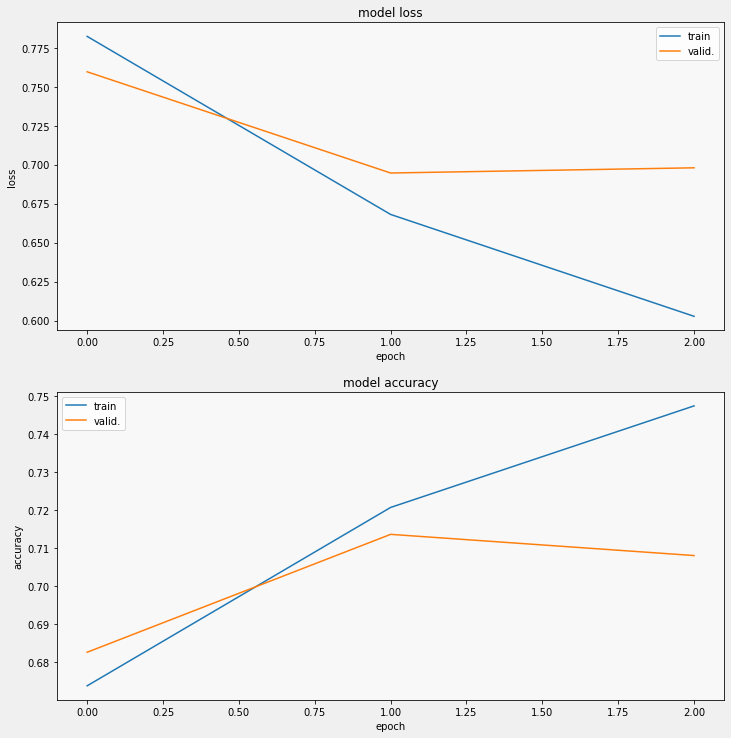

In [61]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['accuracy'],
    history.history['val_accuracy'],
    'accuracy',
    212,
)

In [63]:
model.save('sentiment_model.h5')

# Predictions

In [64]:
def prep_data(text):
    tokens = tokenizer.encode_plus(text, max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

In [70]:
probs = model.predict(prep_data("This movie was terrible"))[0]

probs

array([8.8946927e-01, 9.9371888e-02, 1.0546874e-02, 2.8047289e-04,
       3.3142691e-04], dtype=float32)

In [71]:
np.argmax(probs)

0